In [107]:
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
cos = nn.CosineSimilarity(dim=0, eps=1e-9)
from torchvision import transforms
# from codes.models import ConvNet, resnet8, MLP
from utils import *
from torch.utils.data import DataLoader
from models import *
import random
from collections import Counter
from collections import OrderedDict
import seaborn as sns
import copy
device = "cuda"

# adjustable parameters
alpha_d = 100
local_ep = 20
mali_local_ep = 20
points = 41
global attack 
attack = "tlp" #"backdoor", "tlp"
model_name = "ConvNet" # "resnet8", "ConvNet"
num_classes = 10
dataset ="fmnist"

In [108]:

def get_delta_cos(model1, model2, model0_sd):
    flat_model0 = flat_dict(model0_sd)
    flat_model1 = flat_dict(model1.state_dict())
    flat_model2 = flat_dict(model2.state_dict())
    
    delta = torch.abs(flat_model1 - flat_model2)
    org_cos = cos((flat_model1 - flat_model0), (flat_model2 - flat_model0))
    return delta, 1-org_cos.item()

def model_eval(model, test_loader, attack):
    acc = eval_op_ensemble([model], test_loader)
    if attack == "tlp":
        asr = eval_op_ensemble_tr_lf_attack([model], test_loader)
    elif attack == "backdoor":
        asr = eval_op_ensemble_attack([model], test_loader)
    return list(acc.values())[0], list(asr.values())[0]


def sample_and_replace(model1, model2, model3, k_percent):
    """
    Randomly selects k% of parameters within each layer from model2 and replaces them in model1.
    Returns a new model (model3) with mixed parameters and a dictionary of replaced indices.
    """
    model_1_sd = {key: value.clone() for key, value in model1.state_dict().items()}
    model3.load_state_dict(model_1_sd)  # Start with model1's parameters
    replaced_params = {}
    
    state_dict = model3.state_dict()
    for param_name in model1.state_dict().keys():
        param1 = model1.state_dict()[param_name].clone()
        param2 = model2.state_dict()[param_name].clone()
        num_elements = param1.numel()
        num_replace = int((k_percent / 100) * num_elements)
        
        if num_replace > 0:
            indices = random.sample(range(num_elements), num_replace)
            param1.view(-1)[indices] = param2.view(-1)[indices]
            param1_flat = param1.view(-1)
            param2_flat = param2.view(-1)
            param1_flat[indices] = param2_flat[indices]
            state_dict[param_name] = param1.view(param1.shape)
            replaced_params[param_name] = indices
    
    model3.load_state_dict(state_dict)
    return model3, replaced_params




def sampling_experiment(model1, model2, model3, model0_sd, main_dataloader, device, k_percent, p):
    """
    Runs p sampling experiments, evaluates model3 on both main and side tasks.
    """
    model_1_sd = {key: value.clone() for key, value in model1.state_dict().items()}
    
    results = {}
    replaced_params_list=[]
    for i in range(p):    
        model3.load_state_dict(model_1_sd)
        model3, replaced_params = sample_and_replace(model1, model2, model3, k_percent)
        acc_, asr_  = model_eval(model3, main_dataloader, attack)
        delta, cos_dist = get_delta_cos(model1, model3, model0_sd)
        results[i] = (acc_, asr_, cos_dist)
        replaced_params_list.append({asr_:  replaced_params})
    return results, replaced_params_list, model3


def replaced_params_count(replaced_params_list):
    """
    Counts occurrences of values per layer across multiple replaced_params dictionaries.

    :param replaced_params_list: List of replaced_params dictionaries.
    :return: Dictionary where keys are layer names and values are Counters of occurrences.
    """
    layer_counts = {}

    for replaced_params in replaced_params_list:
        for layer, values in replaced_params.items():
            if layer not in layer_counts:
                layer_counts[layer] = Counter()
            layer_counts[layer].update(values)

    return layer_counts


def convert_to_state_dict(layer_counts, state_dict):
    ind_w = OrderedDict()
    
    # Iterate over the outer dictionary (float keys)
    for weight, layers in layer_counts.items():
        for layer_name, indices in layers.items():
            print("layer_name", layer_name, indices)
            # If the layer is not in state_dict, initialize it with an empty list of zeros
            if layer_name not in ind_w:
                ind_w[layer_name] = {}
            
            for index in range(state_dict[layer_name].numel()):  
                if index in indices:
                    # Add the weight to the corresponding index in the layer
                    if index not in ind_w[layer_name]:
                        ind_w[layer_name][index] = 0
                    ind_w[layer_name][index] += weight
                else:
                    # other not selected indices
                    ind_w[layer_name][index] = 0
            
    
    # print("ind_w keys", ind_w.keys())
    # print("state_dict keys", state_dict.keys())
    
    for name, asr_dict in ind_w.items():
        asr_w = torch.tensor([value for key, value in sorted(asr_dict.items())])
        print(f"name:{name}, asr_w:{asr_w.numel()}, state_dict:{state_dict[name].numel()}")
        state_dict[name] = asr_w.view(state_dict[name].shape)
    
    return state_dict


def plot_layer_weights(layer_name, params, title, save_plot=False):
    """
    Plots the weights of a specific layer in a PyTorch model as a heatmap.
    
    Parameters:
        layer (torch.nn.Module): The PyTorch layer (e.g., torch.nn.Linear, torch.nn.Conv2d).
        layer_name (str): A text string to label the plot and use in the filename.
        save_plot (bool): If True, saves the plot as a PNG file with the layer_name as part of the filename.
    """
    # Check if the layer has weights
    # if not hasattr(layer, 'weight'):
    #     raise ValueError(f"The provided layer does not have weights.")
    
    # Extract the weights
    params = params.reshape(params.size(0), -1)
    
    weights = params.cpu().numpy()
    
    # Plot the weights as a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(weights, cmap="coolwarm", annot=False, cbar=True)
    plt.title(f'Weight Matrix of {layer_name} _ {title}')
    plt.xlabel('Neuron Index')
    plt.ylabel('Input Index')
    
    if save_plot:
        # Save the plot with the layer_name as part of the filename
        filename = f"{layer_name}_{title}_weights_heatmap.png"
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        print(f"Plot saved as {filename}")
    
    plt.show()

In [109]:


# Define transformation (convert images to tensors and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image with mean and std
])

# Load the training dataset
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Load the test dataset
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for batch processing
client_loaders, test_loader, client_data_subsets =\
    data.get_loaders(train_data, test_data, n_clients=100,
                    alpha=alpha_d, batch_size=32, n_data=None, num_workers=4, seed=4)
    
model_fn = partial(models.get_model(model_name)[
                        0], num_classes=num_classes, dataset=dataset)

client_loader = client_loaders[0]

# created models
model1 = model_fn().to(device)
model2 = model_fn().to(device)
model3 = model_fn().to(device)

model0_sd = {k: v.clone().detach() for k, v in model1.state_dict().items()}

optimizer1 = optim.SGD(model1.parameters(), lr=0.001)
optimizer2 = optim.SGD(model2.parameters(), lr=0.001)
optimizer3 = optim.SGD(model3.parameters(), lr=0.001)


Data split:
 - Client 0: [62 62 58 65 57 61 58 53 56 63]                         -> sum=595
 - Client 1: [61 64 63 55 59 58 60 65 57 58]                         -> sum=600
 - Client 2: [54 57 59 60 64 66 62 63 60 54]                         -> sum=599
 - Client 3: [62 56 63 56 62 63 59 58 61 61]                         -> sum=601
 - Client 4: [57 67 62 56 57 65 65 57 54 58]                         -> sum=598
 - Client 5: [54 51 65 59 66 67 53 57 62 68]                         -> sum=602
 - Client 6: [61 65 60 67 53 60 61 50 58 66]                         -> sum=601
 - Client 7: [53 58 49 70 75 63 51 61 54 64]                         -> sum=598
 - Client 8: [64 58 60 52 59 66 65 64 55 59]                         -> sum=602
 - Client 9: [58 63 46 68 61 56 57 66 69 55]                         -> sum=599
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
 - Client 91: [54 61 56 53 60 63 63 62 70 58]                         -> sum=600
 - Client 92: 

In [110]:
# model1 train benign
train_op(model1, client_loader, optimizer1, epochs=local_ep, print_train_loss=True)

model1_sd = {key: value.clone() for key, value in model1.state_dict().items()}

# model2 train from model1
model2.load_state_dict(model1_sd)
if attack == "tlp":
    train_op_tr_flip(model2, client_loader, optimizer2, epochs=mali_local_ep, class_num=10, print_train_loss=True)
elif attack == "backdoor":
    train_op_backdoor(model2, client_loader, optimizer2, epochs=local_ep)

model2_sd = {key: value.clone() for key, value in model2.state_dict().items()}

acc1, asr1 = model_eval(model1, test_loader, attack)
acc2, asr2 = model_eval(model2, test_loader, attack)

# delta, org_cos
delta0, org_cos2 = get_delta_cos(model1, model2, model0_sd)
print(f"model1 acc:{acc1}, asr:{asr1}, cos dist:{0}")
print(f"model2 acc:{acc2}, asr:{asr2}, cos dist:{org_cos2}")

[2.33, 2.28, 2.24, 2.19, 2.15, 2.1, 2.07, 2.04, 2.0, 1.97, 1.95, 1.93, 1.9, 1.88, 1.85, 1.82, 1.8, 1.78, 1.76, 1.73, 1.72, 1.7, 1.68, 1.67, 1.65, 1.63, 1.61, 1.6, 1.58, 1.56, 1.56, 1.54, 1.53, 1.52, 1.5, 1.49, 1.47, 1.46, 1.45, 1.44, 1.43, 1.42, 1.41, 1.4, 1.39, 1.38, 1.37, 1.35, 1.34, 1.34, 1.33, 1.32, 1.31, 1.3, 1.29, 1.28, 1.28, 1.27, 1.26, 1.25, 1.25, 1.24, 1.23, 1.22, 1.22, 1.21, 1.2, 1.2, 1.19, 1.18, 1.18, 1.17, 1.17, 1.16, 1.15, 1.15, 1.14, 1.13, 1.13, 1.12, 1.12, 1.11, 1.11, 1.1, 1.1, 1.09, 1.09, 1.08, 1.08, 1.07, 1.07, 1.06, 1.06, 1.05, 1.05, 1.04, 1.04, 1.04, 1.03, 1.03, 1.02, 1.02, 1.02, 1.01, 1.01, 1.0, 1.0, 1.0, 0.99, 0.99, 0.99, 0.98, 0.98, 0.98, 0.97, 0.97, 0.96, 0.96, 0.96, 0.95, 0.95, 0.95, 0.95, 0.94, 0.94, 0.94, 0.93, 0.93, 0.93, 0.92, 0.92, 0.92, 0.92, 0.91, 0.91, 0.91, 0.91, 0.9, 0.9, 0.9, 0.9, 0.89, 0.89, 0.89, 0.88, 0.88, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.86, 0.86, 0.86, 0.86, 0.85, 0.85, 0.85, 0.85, 0.85, 0.84, 0.84, 0.84, 0.84, 0.84, 0.83, 0.83, 0.83,

In [111]:
def replace_one_layer(model1, model2, model3):
    # replacing each layer in the malicious (model2) with the benigh (model1) to identify BC layers
    model1.eval()
    model2.eval()
    results = {}
    for name, params in model2.state_dict().items():
        model3_sd = copy.deepcopy(model2_sd)
        model3_sd[name] = model1_sd[name].clone()
        model3.load_state_dict(model3_sd)
        
        acc1, asr1 = model_eval(model3, test_loader, attack)

        # delta, org_cos
        delta, cos_dist = get_delta_cos(model1, model3, model0_sd)
        print(name, acc1, asr1, cos_dist)
        results[name] = (acc1, asr1, cos_dist)
    return results

In [112]:
results1 = replace_one_layer(model1, model2, model3)

features.0.weight 0.6843 0.875 0.052439749240875244
features.0.bias 0.6839 0.876 0.05251634120941162
features.1.weight 0.6839 0.876 0.05251502990722656
features.1.bias 0.6839 0.876 0.05251532793045044
features.4.weight 0.6797 0.828 0.049371957778930664
features.4.bias 0.6839 0.876 0.05251634120941162
features.5.weight 0.6839 0.876 0.05251574516296387
features.5.bias 0.6839 0.876 0.05251586437225342
features.8.weight 0.6831 0.804 0.04880565404891968
features.8.bias 0.6839 0.876 0.05251634120941162
features.9.weight 0.6839 0.876 0.05252724885940552
features.9.bias 0.6839 0.876 0.05251908302307129
classifier.weight 0.7506 0.048 0.03429657220840454
classifier.bias 0.6839 0.876 0.05250203609466553


In [113]:
# model1.load_state_dict(model1_sd)
# model2.load_state_dict(model2_sd)
# results2 = replace_one_layer(model2, model1, model3)

In [114]:
def plot_critical_layers(data):
    # Extracting keys and values
    keys = list(data.keys())
    acc_values = [value[0] for value in data.values()]
    asr_values = [value[1] for value in data.values()]
    cos_dist_values = [value[2] for value in data.values()]

    # Setting up the plot
    plt.figure(figsize=(12, 6))

    # Plotting the lines
    plt.plot(keys, acc_values, marker='o', label='Acc', linestyle='-', color='blue')
    plt.plot(keys, asr_values, marker='s', label='ASR', linestyle='--', color='green')
    plt.plot(keys, cos_dist_values, marker='^', label='Cos_dist', linestyle='-.', color='red')

    # Adding labels, title, and custom x-axis tick labels
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.title('Acc, ASR, and Cos dist for each layer')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.legend()

    # Adding grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Adjust layout to make room for the rotated x-axis labels
    plt.tight_layout()

    # Show the plot
    plt.show()

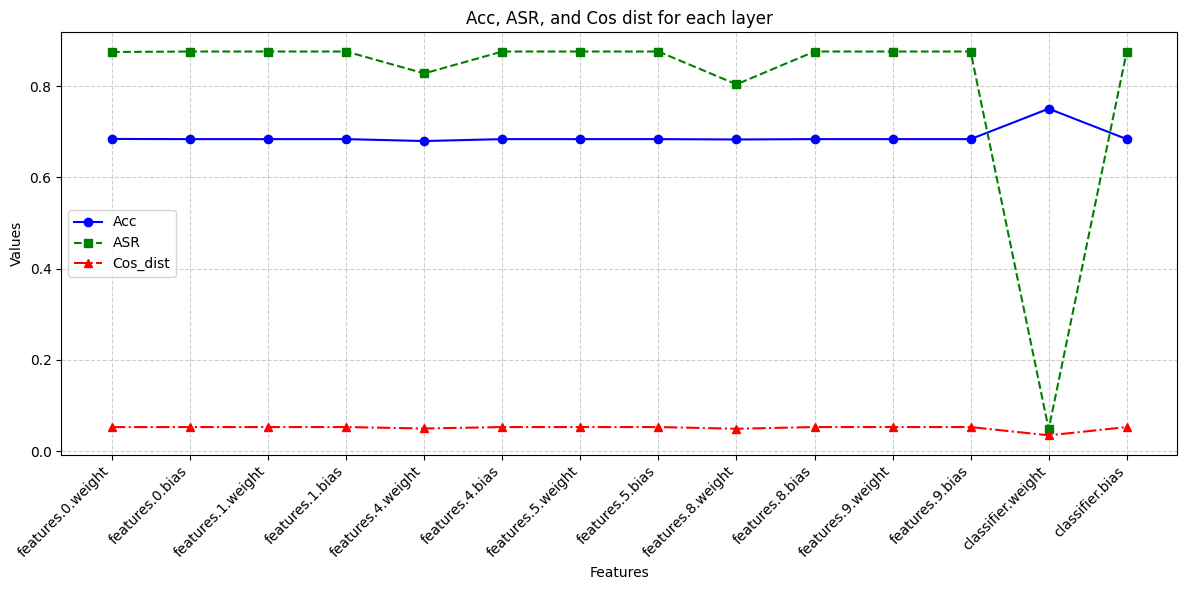

In [115]:
plot_critical_layers(results1)

In [116]:
model1.eval()
model2.eval()
results3 = {}

for name, params in model2.state_dict().items():
    model3_sd = copy.deepcopy(model1_sd)
    model3_sd[name] = model2_sd[name].clone()
    model3.load_state_dict(model3_sd)

    acc1, asr1 = model_eval(model3, test_loader, attack)

    # delta, org_cos
    delta, cos_dist = get_delta_cos(model1, model3, model0_sd)
    print(name, acc1, asr1, cos_dist)
    results3[name] = (acc1, asr1, cos_dist)

features.0.weight 0.7446 0.011 0.00036156177520751953
features.0.bias 0.7449 0.011 -1.1920928955078125e-07
features.1.weight 0.745 0.011 5.602836608886719e-06
features.1.bias 0.745 0.011 4.708766937255859e-06
features.4.weight 0.7574 0.017 0.015975475311279297
features.4.bias 0.7449 0.011 -1.1920928955078125e-07
features.5.weight 0.745 0.011 1.0728836059570312e-05
features.5.bias 0.7449 0.011 6.020069122314453e-06
features.8.weight 0.7531 0.023 0.023146390914916992
features.8.bias 0.7449 0.011 -1.1920928955078125e-07
features.9.weight 0.7448 0.011 0.00029772520065307617
features.9.bias 0.7449 0.011 9.620189666748047e-05
classifier.weight 0.6756 0.679 0.04355430603027344
classifier.bias 0.7452 0.011 3.3855438232421875e-05


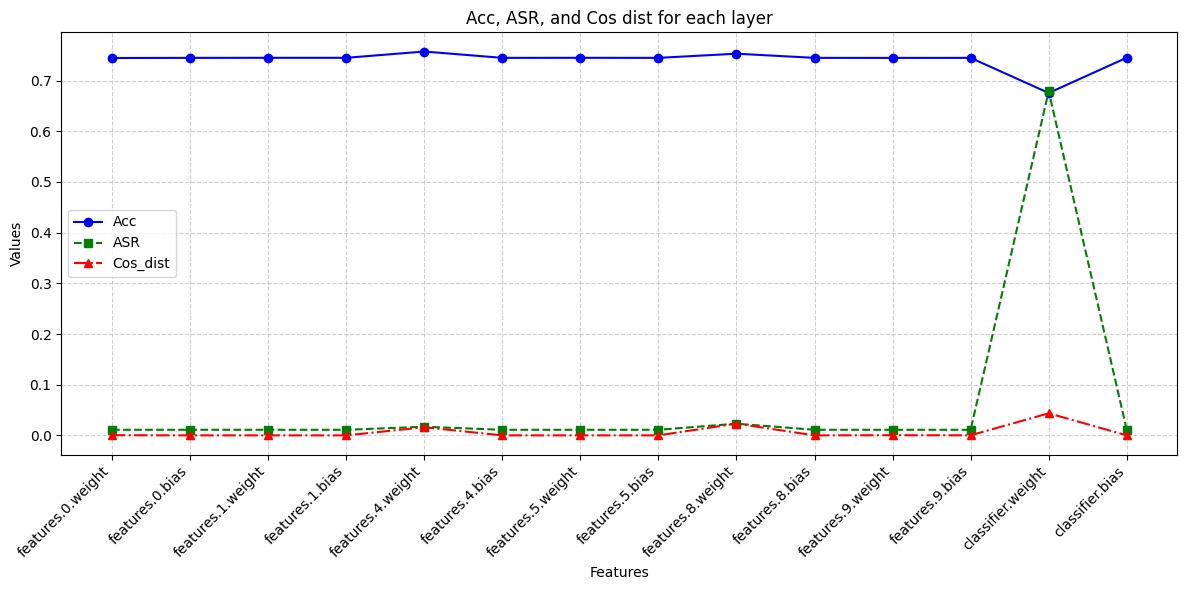

In [117]:
plot_critical_layers(results3)

In [122]:
# selected_layer = "classification_layer.weight"
selected_layer = "classifier.weight"

In [123]:
model3_sd = copy.deepcopy(model1_sd)
model3_sd[selected_layer] = model2_sd[selected_layer].clone()
model3.load_state_dict(model3_sd)

acc1, asr1 = model_eval(model3, test_loader, attack)

# delta, org_cos
delta, cos_dist1 = get_delta_cos(model1, model3, model0_sd)
print(f"for {dataset} data, in {model_name}, with {attack}, acc: {acc1}, asr: {asr1}, cos_dist: {cos_dist1}")

for fmnist data, in ConvNet, with tlp, acc: 0.6756, asr: 0.679, cos_dist: 0.04355430603027344


In [124]:
def plot_layer_weights(layer_w, layer_name, save_plot=False):
    """
    Plots the weights of a specific layer in a PyTorch model as a heatmap.
    
    Parameters:
        layer (torch.nn.Module): The PyTorch layer (e.g., torch.nn.Linear, torch.nn.Conv2d).
        layer_name (str): A text string to label the plot and use in the filename.
        save_plot (bool): If True, saves the plot as a PNG file with the layer_name as part of the filename.
    """
    
    # Extract the weights
    weights = layer_w.cpu().numpy()
    
    # Plot the weights as a heatmap
    plt.figure(figsize=(20, 3))
    sns.heatmap(weights, cmap="coolwarm", annot=False, cbar=True)
    plt.title(f'Weight Matrix of {layer_name}')
    plt.xlabel('Neuron Index')
    plt.ylabel('Input Index')
    
    if save_plot:
        # Save the plot with the layer_name as part of the filename
        filename = f"{layer_name}_weights_heatmap.png"
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        print(f"Plot saved as {filename}")
    
    plt.show()

In [125]:
model1.state_dict()[selected_layer].size()

torch.Size([10, 2048])

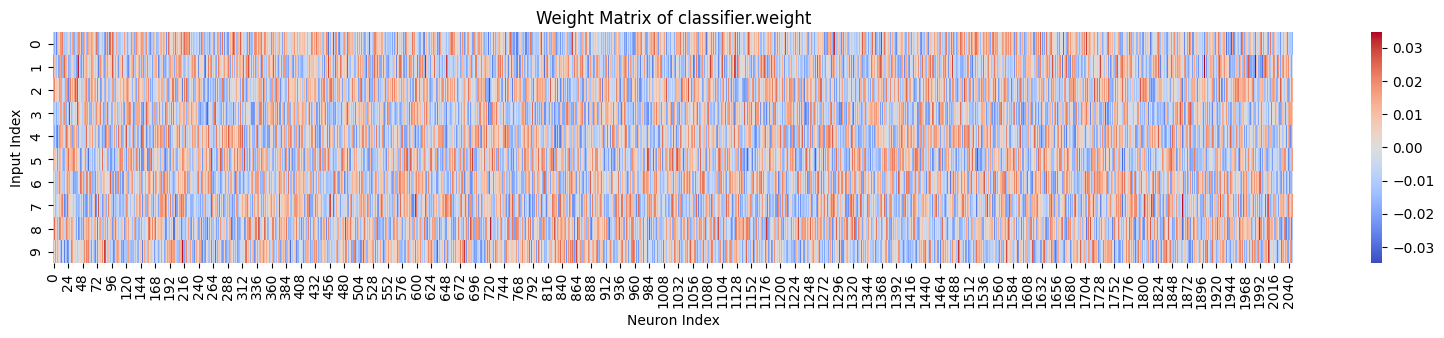

In [126]:
plot_layer_weights(model1.state_dict()[selected_layer], selected_layer, save_plot=False)

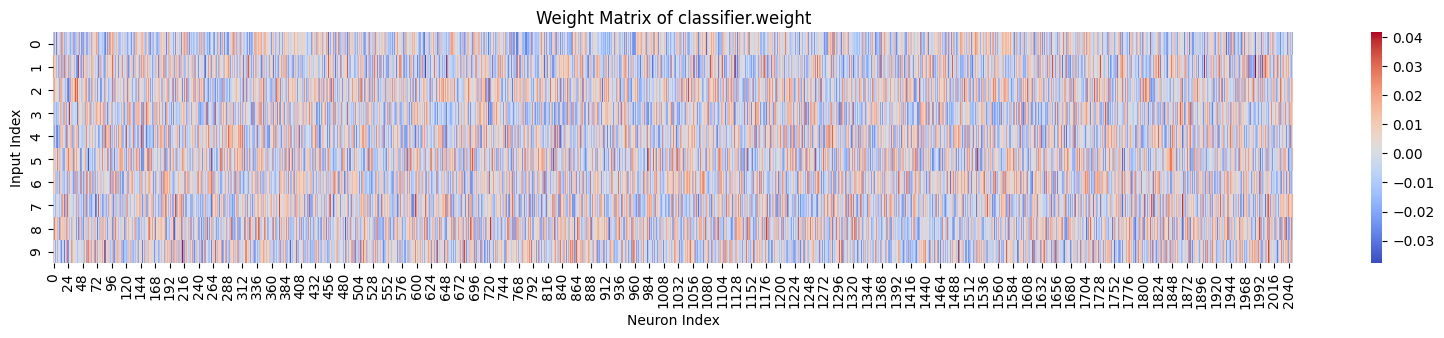

In [127]:
plot_layer_weights(model2.state_dict()[selected_layer], selected_layer, save_plot=False)

In [128]:
m1_cw = model1.state_dict()[selected_layer]
m2_cw = model2.state_dict()[selected_layer]

In [129]:
delta_cw = m2_cw - m1_cw

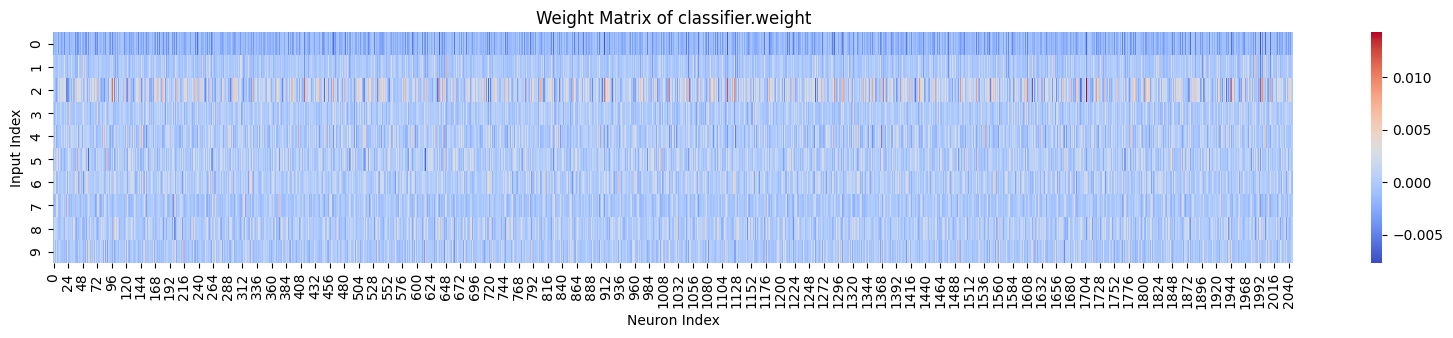

In [130]:
plot_layer_weights(delta_cw, selected_layer, save_plot=False)

In [ ]:
m2_cw

tensor([[ 0.0341,  0.0217, -0.0163,  ..., -0.0115,  0.0169, -0.0063],
        [ 0.0159, -0.0262,  0.0015,  ...,  0.0253,  0.0407,  0.0196],
        [-0.0157,  0.0137, -0.0407,  ...,  0.0034,  0.0199, -0.0235],
        ...,
        [ 0.0324, -0.0139, -0.0103,  ..., -0.0246, -0.0069,  0.0316],
        [-0.0002,  0.0302, -0.0439,  ...,  0.0349, -0.0264, -0.0452],
        [ 0.0209, -0.0450, -0.0341,  ...,  0.0191, -0.0074,  0.0226]],
       device='cuda:0')

In [ ]:
def compute_similarity_and_distance(a, b):
    """
    Compute cosine similarity and L2 distance between two tensors.

    Args:
        a (torch.Tensor): First tensor.
        b (torch.Tensor): Second tensor.

    Returns:
        cos_sim (float): Cosine similarity between a and b.
        l2_dist (float): L2 distance (Euclidean distance) between a and b.
    """
    # Ensure the tensors are of the same size
    assert a.size() == b.size(), "Tensors must be of the same size"

    # Compute cosine similarity
    cos_sim = torch.nn.functional.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0))
    print(cos_sim)

    # Compute L2 distance (Euclidean distance)
    l2_dist = torch.norm(a - b, p=2)

    return cos_sim.item(), l2_dist.item()

In [ ]:
m1_cw.flatten().size()

torch.Size([5120])

In [ ]:
compute_similarity_and_distance(m1_cw, m2_cw)

tensor([[0.9988, 0.9988, 0.9996, 0.9994, 0.9990, 0.9996, 0.9950, 0.9977, 0.9992,
         0.9985, 0.9986, 0.9972, 0.9982, 0.9984, 0.9989, 0.9987, 0.9994, 0.9983,
         0.9996, 0.9988, 0.9987, 0.9994, 0.9986, 0.9995, 0.9989, 0.9985, 0.9985,
         0.9992, 0.9988, 0.9984, 0.9992, 0.9993, 0.9990, 0.9981, 0.9980, 0.9982,
         0.9977, 0.9985, 0.9978, 0.9973, 0.9979, 0.9965, 0.9991, 0.9986, 0.9976,
         0.9984, 0.9992, 0.9985, 0.9994, 0.9997, 0.9989, 0.9993, 0.9978, 0.9983,
         0.9964, 0.9982, 0.9986, 0.9994, 0.9984, 0.9988, 0.9993, 0.9994, 0.9983,
         0.9988, 0.9991, 0.9976, 0.9982, 0.9995, 0.9974, 0.9996, 0.9984, 0.9978,
         0.9983, 0.9986, 0.9991, 0.9989, 0.9989, 0.9978, 0.9969, 0.9982, 0.9989,
         0.9983, 0.9987, 0.9989, 0.9990, 0.9972, 0.9978, 0.9995, 0.9987, 0.9981,
         0.9994, 0.9973, 0.9990, 0.9984, 0.9969, 0.9989, 0.9994, 0.9987, 0.9991,
         0.9979, 0.9989, 0.9993, 0.9987, 0.9996, 0.9990, 0.9991, 0.9984, 0.9985,
         0.9985, 0.9983, 0.9

RuntimeError: a Tensor with 512 elements cannot be converted to Scalar

In [ ]:
import torch
import torch.nn as nn
import copy

def merge_models(a_state_dict: dict, b_state_dict: dict, layer_name: str, k: float) -> dict:
    """
    Creates a new model c, which is initialized from a_state_dict, except that k% of the parameters
    in the specified layer are taken from b_state_dict.

    Args:
        a_state_dict (dict): State dictionary of the first model.
        b_state_dict (dict): State dictionary of the second model (same structure as a_state_dict).
        layer_name (str): Name of the layer to partially merge (e.g., "classifier.weight").
        k (float): Percentage of elements to take from b (0 < k <= 1).

    Returns:
        dict: State dictionary of the new model c with mixed parameters.
    """
    c_state_dict = copy.deepcopy(a_state_dict)  # Clone a's state dict
    
    # Get the parameters of the specified layer from a and b
    a_params = a_state_dict[layer_name]
    b_params = b_state_dict[layer_name]
    c_params = c_state_dict[layer_name]
    
    num_params = a_params.numel()
    num_selected = int(k * num_params)
    
    # Generate random indices to select k% of the parameters
    indices = torch.randperm(num_params)[:num_selected]
    
    # Flatten tensors for easy indexing
    a_params_flat = a_params.clone().view(-1)
    b_params_flat = b_params.clone().view(-1)
    c_params_flat = c_params.clone().view(-1)
    
    # Copy selected indices from b to c
    c_params_flat[indices] = b_params_flat[indices]
    
    # Reshape c's parameters back to original shape
    with torch.no_grad():
        c_params.copy_(c_params_flat.view(a_params.shape))
    
    return c_state_dict

# Example usage:
a = nn.Linear(10, 5)
b = nn.Linear(10, 5)

a_state_dict = a.state_dict()
b_state_dict = b.state_dict()

c_state_dict = merge_models(a_state_dict, b_state_dict, "weight", 0.3)  # 30% of classifier.weight from b


In [ ]:
a.weight

Parameter containing:
tensor([[-0.0781,  0.1921, -0.2532, -0.2798,  0.2396, -0.1817, -0.3037,  0.2608,
          0.2267, -0.0686],
        [-0.1987,  0.1640, -0.2764,  0.2951, -0.3012, -0.2229,  0.1932, -0.2334,
         -0.1174, -0.1723],
        [ 0.3109,  0.1289, -0.2838, -0.2999, -0.1709,  0.2323,  0.2932,  0.2684,
         -0.1388,  0.2993],
        [-0.2490,  0.2265,  0.2919, -0.0134,  0.0390,  0.0876,  0.0830,  0.1562,
          0.2525, -0.1859],
        [-0.2518,  0.1278,  0.0980, -0.3036,  0.2789, -0.0303, -0.1960,  0.0725,
          0.1476,  0.2230]], requires_grad=True)

In [ ]:
indices = torch.randperm(10)[:5]

In [ ]:
indices

tensor([4, 0, 8, 7, 9])